### Instalar Librerias

In [15]:
pip install openbabel

Note: you may need to restart the kernel to use updated packages.


In [30]:
import rdkit
import openbabel
import pandas as pd
import numpy as np
from openbabel import pybel
from rdkit.Chem import PandasTools


### Cargar Datos

Los datos para este trabajo se obtuvieron de la página oficial de la competencia Tox 21 Data Challenge realizada en 2014 (https://tripod.nih.gov/tox21/challenge/data.jsp). Se decidió para mayor simplificación trabajar únicamente con 1 de los 12 efectos tóxicos evaluados en la competencia. Éste es el efecto NR-ER que es una respuesta tóxica del receptor nuclear. La elección del mismo fue buscando un efecto que tenga un valor de activos/total del dataset promedio entre todos los efectos.
Los compuestos se descargaron en formato SDF y se calculo una serie de descriptores predefinidos que servirá como input de la red. 

In [31]:
#Cargar el archivo SDF con Compuestos y Rta Toxica para visualizarlos:

sdf_file = 'nr-er_removed.sdf' 

,Formula,FW,DSSTox_CID,Active,ID,ROMol
0,C17H17ClF6N2O,414.7731 (378.3122+36.4609),27796,1,NCGC00161831-02,
1,C30H35NO3,457.6038,26844,0,NCGC00181100-01,
2,C12H11N7,253.2626,1373,0,NCGC00016016-10,
3,C25H24F6N4,494.4753,3868,1,NCGC00257010-01,
4,C27H60ClNO3Si,510.3087 (474.8552+35.4535),15589,0,NCGC00255696-01,
...,...,...,...,...,...,...
7692,C7H10N2OS,170.2321,1209,0,NCGC00259290-01,
7693,C3H6N2S,102.1581,601,0,NCGC00258846-01,
7694,C3H6N2S,102.1581,601,0,NCGC00254936-01,
7695,C10H14NO5PS,291.2606,1100,0,NCGC00254571-01,

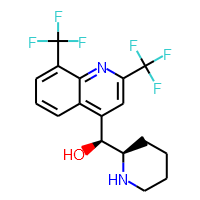
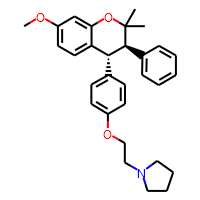
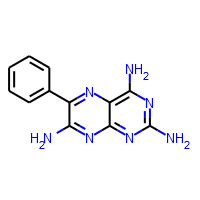
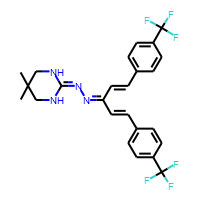
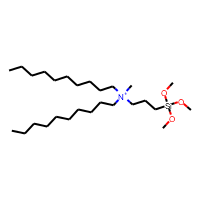
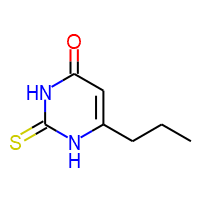
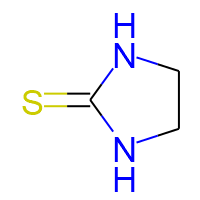
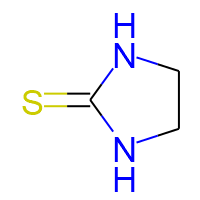
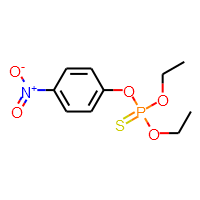
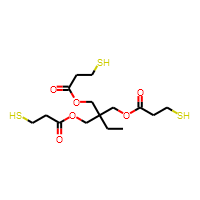

In [32]:
df_nr_ar = PandasTools.LoadSDF(sdf_file) #Abre el archivo SDF como un pandas df.
df_nr_ar #Visualizamos.

In [33]:
df_nr_ar.shape #En realidad hay 5 compuestos mas. RDKit no los reconoce por eso no los abre..
               #Para la visualizacion no hay problema.

(7693, 6)

Previo al calculo de los descriptores, se utilizó la funcion Find the largest fragment de Open Babel para eliminar agregados en los compuestos en la linea de comando. La funcion se indica con -r.

obabel "nr-er.sdf" -O "nr-er_removed.sdf" -r

El nuevo archivo sdf se llamo nr-ar_removed.sdf y es el que se carga a continuacion. 

In [34]:
#Leer archivo SDF con Pybel para calcular descriptores:

mols_removed = pybel.readfile("sdf", "nr-er_removed.sdf")

In [45]:
#Leer target:

actives_f = open("nr_er_activity.txt", "r")
nr_ar_activity = []
for x in actives_f:
    nr_ar_activity.append(x[0])
nr_ar_activity = [int(i) for i in nr_ar_activity]
y = np.array(nr_ar_activity)

Debajo puede verse la cantidad de compuestos de cada clase. Como se ve, el dataset esta desbalanceado siendo que hay únicamente un x% de compuestos activos frente al total. De todas formas, éstos valores son representativos de la realidad. Ésta proporción fue tenida en cuenta a la hora de decidir qué metricas utilizar para encontrar los hiperparámetros que mejor se ajusten al modelo y para evaluar la capacidad del mismo. 

In [46]:
#Vemos compuestos Activos vs Inactivos.
column = 'Active'
activos = sum(y)
inactivos = sum(y == 0)*1
indices = ['Activos','Inactivos']
activity_df = pd.DataFrame(data = [activos, inactivos], columns = ['NR-ER'], index = indices)
activity_df

,NR-ER
Activos,937
Inactivos,6760


In [47]:
print(len(y))

7697


### Calculo de descriptores con pybel

Para el calculo de descriptores, se utilizo la clase pybel dentro de Open Babel. Esta tiene una serie predefinida de descriptores estáticos (únicamente de propiedades de su estructura y secuencia) que se demostró que sirven para representar a los compuestos quimicos en metodos computacionales. De todas formas, existen cientos de descriptores tanto estáticos como dinámicos que podrían calcularse. Para simplificar, en este trabajo se parte de estos 26 descriptores.

In [41]:
pybel.descs #Lista de descriptores disponibles.

['abonds',
 'atoms',
 'bonds',
 'cansmi',
 'cansmiNS',
 'dbonds',
 'formula',
 'HBA1',
 'HBA2',
 'HBD',
 'InChI',
 'InChIKey',
 'L5',
 'logP',
 'MP',
 'MR',
 'MW',
 'nF',
 'rotors',
 's',
 'sbonds',
 'smarts',
 'tbonds',
 'title',
 'TPSA']

In [42]:
#Calculmos descriptores para cada compuesto:

props = []
names =[]

for molecule in mols_removed:  # iteracion en moleculas
    molecule.OBMol.AddHydrogens() #Agrega hidrogenos a ph =7
    desc=molecule.calcdesc()    #calcula descriptores predeterminados en la lista de arriba. Output Dictionary.
    c=molecule.charge # calcula carga
    desc['CHARGE']=c # agrega al diccionario.
    props.append(desc)  # diccionario a lista.
    names.append(molecule.title)

In [43]:
props #Descriptores calculados.

[{'abonds': 11.0,
  'atoms': 42.0,
  'bonds': 44.0,
  'cansmi': nan,
  'cansmiNS': nan,
  'dbonds': 0.0,
  'formula': nan,
  'HBA1': 19.0,
  'HBA2': 3.0,
  'HBD': 2.0,
  'InChI': nan,
  'InChIKey': nan,
  'L5': nan,
  'logP': 4.7767,
  'MP': 133.02669999999986,
  'MR': 86.5125,
  'MW': 378.3121592000001,
  'nF': 6.0,
  'rotors': 4.0,
  's': nan,
  'sbonds': 33.0,
  'smarts': nan,
  'tbonds': 0.0,
  'title': nan,
  'TPSA': 45.150000000000006,
  'CHARGE': 0},
 {'abonds': 18.0,
  'atoms': 69.0,
  'bonds': 73.0,
  'cansmi': nan,
  'cansmiNS': nan,
  'dbonds': 0.0,
  'formula': nan,
  'HBA1': 39.0,
  'HBA2': 4.0,
  'HBD': 0.0,
  'InChI': nan,
  'InChIKey': nan,
  'L5': nan,
  'logP': 6.194400000000002,
  'MP': 139.76609999999982,
  'MR': 140.93500000000006,
  'MW': 457.6038000000004,
  'nF': 0.0,
  'rotors': 7.0,
  's': nan,
  'sbonds': 55.0,
  'smarts': nan,
  'tbonds': 0.0,
  'title': nan,
  'TPSA': 30.93,
  'CHARGE': 0},
 {'abonds': 17.0,
  'atoms': 30.0,
  'bonds': 32.0,
  'cansmi': nan

In [48]:
print(len(props))
print(len(y))

7697
7697


In [24]:
#Descriptores a un Data Frame de Pandas:

descriptors = pd.DataFrame(data = props)
descriptors.head()

,abonds,atoms,bonds,cansmi,cansmiNS,dbonds,formula,HBA1,HBA2,HBD,...,MW,nF,rotors,s,sbonds,smarts,tbonds,title,TPSA,CHARGE
0,11.0,42.0,44.0,NaN,NaN,0.0,NaN,19.0,3.0,2.0,...,378.312159,6.0,4.0,NaN,33.0,NaN,0.0,NaN,45.15,0
1,18.0,69.0,73.0,NaN,NaN,0.0,NaN,39.0,4.0,0.0,...,457.603800,0.0,7.0,NaN,55.0,NaN,0.0,NaN,30.93,0
2,17.0,30.0,32.0,NaN,NaN,0.0,NaN,18.0,7.0,3.0,...,253.262640,0.0,1.0,NaN,15.0,NaN,0.0,NaN,129.62,0
3,12.0,59.0,61.0,NaN,NaN,4.0,NaN,28.0,4.0,2.0,...,494.475279,6.0,7.0,NaN,45.0,NaN,0.0,NaN,48.78,0
4,0.0,92.0,91.0,NaN,NaN,0.0,NaN,64.0,3.0,0.0,...,474.855700,0.0,25.0,NaN,91.0,NaN,0.0,NaN,27.69,1


In [25]:
descriptors = descriptors.fillna(0) #LLenamos con 0.

Finalmente exportamos los descriptores en un archivo csv que se abrirá en la notebook tox21_ModelPrep.ipynb

In [49]:
#Guardamos el archivo para abrirlo en la proxima notebook.
descriptors.to_csv('C:/Users/meui_/Descriptores_nr_er.csv')